In [ ]:
import os

# Download the dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# Extract the dataset
!tar -xzf aclImdb_v1.tar.gz

# Verify extraction by listing directory contents
!ls aclImdb/
!ls aclImdb/train/
!ls aclImdb/test/

--2025-07-16 04:26:11--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  17.0MB/s    in 8.0s    

2025-07-16 04:26:19 (10.1 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [ ]:
import pandas as pd
from sklearn.datasets import load_files

# Load the training data
try:
    reviews_train = load_files('./aclImdb/train')
    X_train, y_train = reviews_train.data, reviews_train.target

    # Load the test data
    reviews_test = load_files('./aclImdb/test')
    X_test, y_test = reviews_test.data, reviews_test.target

    # Create dataframes
    df_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})
    df_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})

    # The target variable is 0 for negative and 1 for positive.
    # We can map this to 'negative' and 'positive' for clarity.
    df_train['sentiment'] = df_train['sentiment'].map({0: 'negative', 1: 'positive'})
    df_test['sentiment'] = df_test['sentiment'].map({0: 'negative', 1: 'positive'})

    print("Successfully loaded IMDb dataset.")
    print("Training data shape:", df_train.shape)
    print("Testing data shape:", df_test.shape)
    display(df_train.head())
    display(df_test.head())

    df_sentiment = pd.concat([df_train, df_test], ignore_index=True)
    print("\nCombined dataset shape:", df_sentiment.shape)
    display(df_sentiment.head())

except FileNotFoundError:
    print("IMDb dataset not found in the expected path './aclImdb'.")
    print("Please ensure the dataset was downloaded and extracted correctly.")
    df_sentiment = None

# Note: This dataset only contains positive and negative sentiments.
# The original task mentioned neutral, so we will acknowledge this limitation
# for the sentiment lexicon creation step.

Successfully loaded IMDb dataset.
Training data shape: (75000, 2)
Testing data shape: (25000, 2)


,review,sentiment
0,b'Full of (then) unknown actors TSF is a great...,NaN
1,"b""Amount of disappointment I am getting these ...",NaN
2,"b'The future, we are told, are what we make of...",NaN
3,"b""Dan Katzir has produced a wonderful film tha...",positive
4,b'If you want Scream or anything like the big-...,positive


,review,sentiment
0,"b""Don't hate Heather Graham because she's beau...",positive
1,b'I don\'t know how this movie has received so...,negative
2,"b""I caught this movie on the Horror Channel an...",positive
3,b'NBC had a chance to make a powerful religiou...,negative
4,"b""Looking for something shocking? Okay fine......",negative



Combined dataset shape: (100000, 2)


,review,sentiment
0,b'Full of (then) unknown actors TSF is a great...,NaN
1,"b""Amount of disappointment I am getting these ...",NaN
2,"b'The future, we are told, are what we make of...",NaN
3,"b""Dan Katzir has produced a wonderful film tha...",positive
4,b'If you want Scream or anything like the big-...,positive


## Data Preprocessing

### Subtask:
Clean the text data by removing special characters, converting to lowercase, and handling any inconsistencies.

In [ ]:
import re

def preprocess_text(text):
    # Ensure text is a string and decode if it's bytes
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')

    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if df_sentiment is not None:
    # Remove rows with NaN sentiment
    df_sentiment.dropna(subset=['sentiment'], inplace=True)
    df_sentiment['cleaned_review'] = df_sentiment['review'].apply(preprocess_text)
    print("Text preprocessing complete and rows with missing sentiment removed.")
    display(df_sentiment[['review', 'cleaned_review', 'sentiment']].head())
    print("\nUpdated dataset shape:", df_sentiment.shape)
else:
    print("Dataset not loaded. Skipping preprocessing.")

Text preprocessing complete and rows with missing sentiment removed.


,review,cleaned_review,sentiment
3,"b""Dan Katzir has produced a wonderful film tha...",dan katzir has produced a wonderful film that ...,positive
4,b'If you want Scream or anything like the big-...,if you want scream or anything like the bigstu...,positive
9,"b""Outlandish premise that rates low on plausib...",outlandish premise that rates low on plausibil...,negative
11,b'Let\'s face it-- if you rented a STDVD seque...,lets face it if you rented a stdvd sequel of a...,negative
12,b'Bizarre Tobe Hooper exercise regarding an un...,bizarre tobe hooper exercise regarding an unfo...,negative



Updated dataset shape: (50000, 3)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
     nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize_and_root(text):
    if not isinstance(text, str):
        return []
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and apply stemming
    # Using stemming for simplicity
    rooted_tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    return rooted_tokens

if df_sentiment is not None:
    df_sentiment['rooted_tokens'] = df_sentiment['cleaned_review'].apply(tokenize_and_root)
    print("Tokenization and root form extraction complete.")
    display(df_sentiment[['cleaned_review', 'rooted_tokens', 'sentiment']].head())
else:
    print("Dataset not loaded. Skipping tokenization and rooting.")

Tokenization and root form extraction complete.


,cleaned_review,rooted_tokens,sentiment
3,dan katzir has produced a wonderful film that ...,"[dan, katzir, produc, wonder, film, take, us, ...",positive
4,if you want scream or anything like the bigstu...,"[want, scream, anyth, like, bigstudio, horror,...",positive
9,outlandish premise that rates low on plausibil...,"[outlandish, premis, rate, low, plausibl, unfo...",negative
11,lets face it if you rented a stdvd sequel of a...,"[let, face, rent, stdvd, sequel, forgotten, 80...",negative
12,bizarre tobe hooper exercise regarding an unfo...,"[bizarr, tobe, hooper, exercis, regard, unfort...",negative


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

if df_sentiment is not None and 'rooted_tokens' in df_sentiment.columns:
    # Convert the list of rooted tokens back to a string for TF-IDF
    df_sentiment['rooted_text'] = df_sentiment['rooted_tokens'].apply(lambda tokens: ' '.join(tokens))

    # Initialize TF-IDF Vectorizer
    # You can adjust parameters like max_features, min_df, max_df, ngram_range
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

    # Fit and transform the rooted text data
    X = tfidf_vectorizer.fit_transform(df_sentiment['rooted_text'])
    y = df_sentiment['sentiment']

    print("TF-IDF vectorization complete.")
    print("Shape of the feature matrix (X):", X.shape)
    print("Shape of the target variable (y):", y.shape)

    # Display the first few rows of the vectorized data (as a dense array for viewing)
    # Note: This is for demonstration; keep as sparse matrix for training
    # display(pd.DataFrame(X.todense(), columns=tfidf_vectorizer.get_feature_names_out()).head())
else:
    print("Dataset not loaded or rooted tokens not found. Skipping TF-IDF vectorization.")

TF-IDF vectorization complete.
Shape of the feature matrix (X): (50000, 5000)
Shape of the target variable (y): (50000,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets
# We'll use a standard 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Initialize and train a Logistic Regression model
# Logistic Regression is a common baseline model for text classification
model = LogisticRegression(max_iter=1000) # Increase max_iter for convergence
model.fit(X_train, y_train)

print("\nLogistic Regression model trained successfully.")

Data split into training and testing sets.
Shape of X_train: (40000, 5000)
Shape of X_test: (10000, 5000)
Shape of y_train: (40000,)
Shape of y_test: (10000,)

Logistic Regression model trained successfully.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

if 'model' in locals() and X_test is not None and y_test is not None:
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Model Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Print a detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

else:
    print("Model not found or test data not available. Skipping model evaluation.")

Model Evaluation Results:
Accuracy: 0.8916
Precision: 0.8917
Recall: 0.8916
F1-score: 0.8916

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4939
    positive       0.89      0.90      0.89      5061

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



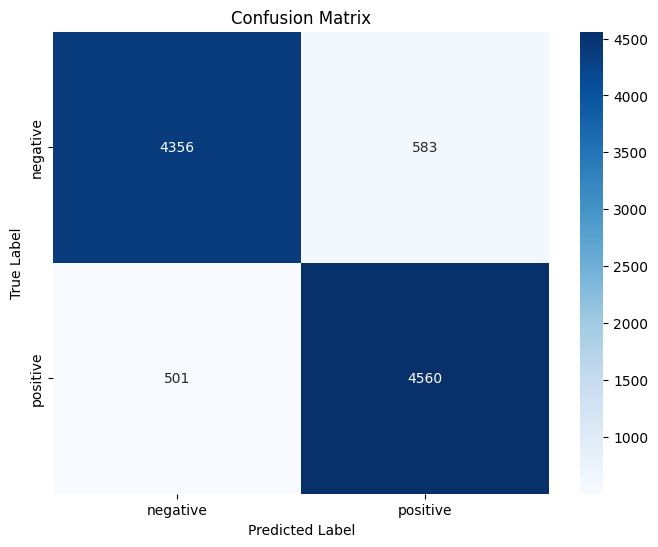


Confusion Matrix:
[[4356  583]
 [ 501 4560]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if 'y_test' in globals() and 'y_pred' in globals():
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Get the class labels from the test data
    # Ensure the labels are in the correct order for the confusion matrix
    labels = sorted(y_test.unique())

    # Display the confusion matrix using seaborn for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nConfusion Matrix:")
    print(cm)

else:
    print("Test labels (y_test) or predicted labels (y_pred) not available. Cannot generate confusion matrix.")

In [ ]:
# Improve the sentiment analysis model's ability to handle negation by modifying the TF-IDF vectorization to include n-grams
# retraining the Logistic Regression model, and re-evaluating its performance.
# Initialize a new TfidfVectorizer object with ngram_range
tfidf_vectorizer_ngram = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, ngram_range=(1, 3))

# Apply fit_transform to the rooted_text column
X_ngram = tfidf_vectorizer_ngram.fit_transform(df_sentiment['rooted_text'])

# Update the target variable y
y_ngram = df_sentiment['sentiment']

# Print the shapes
print("TF-IDF vectorization with n-grams complete.")
print("Shape of the new feature matrix (X_ngram):", X_ngram.shape)
print("Shape of the target variable (y_ngram):", y_ngram.shape)

TF-IDF vectorization with n-grams complete.
Shape of the new feature matrix (X_ngram): (50000, 5000)
Shape of the target variable (y_ngram): (50000,)


In [ ]:
# RE-TRAIN the model to obtain a better accuracy using the updated TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets using the n-gram features
X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(X_ngram, y_ngram, test_size=0.2, random_state=42)

print("Data split into training and testing sets with n-grams.")
print("Shape of X_train_ngram:", X_train_ngram.shape)
print("Shape of X_test_ngram:", X_test_ngram.shape)
print("Shape of y_train_ngram:", y_train_ngram.shape)
print("Shape of y_test_ngram:", y_test_ngram.shape)

# Initialize and train a new Logistic Regression model with n-gram features
model_ngram = LogisticRegression(max_iter=1000)
model_ngram.fit(X_train_ngram, y_train_ngram)

print("\nLogistic Regression model trained successfully with n-gram features.")

Data split into training and testing sets with n-grams.
Shape of X_train_ngram: (40000, 5000)
Shape of X_test_ngram: (10000, 5000)
Shape of y_train_ngram: (40000,)
Shape of y_test_ngram: (10000,)

Logistic Regression model trained successfully with n-gram features.


N-gram Model Evaluation Results:
Accuracy: 0.8924
Precision: 0.8925
Recall: 0.8924
F1-score: 0.8924

N-gram Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4939
    positive       0.89      0.90      0.89      5061

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



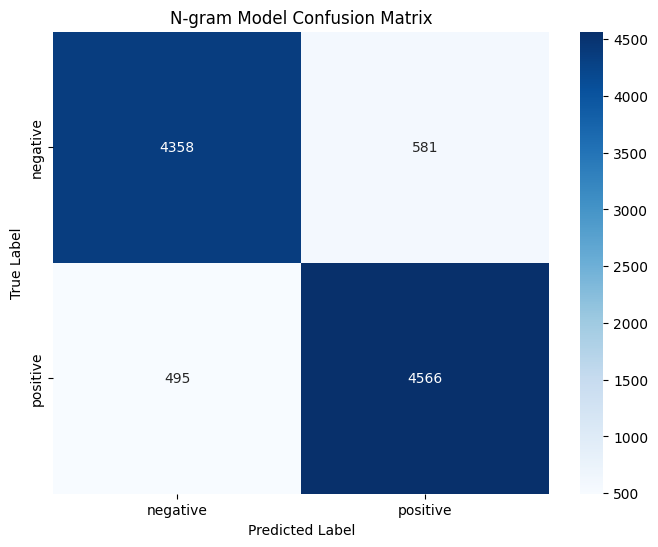


N-gram Confusion Matrix:
[[4358  581]
 [ 495 4566]]


In [ ]:
#RE-EVALUATE the model using the updated TF-IDF

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if 'model_ngram' in globals() and X_test_ngram is not None and y_test_ngram is not None:
    # Make predictions on the test data using the n-gram model
    y_pred_ngram = model_ngram.predict(X_test_ngram)

    # Calculate evaluation metrics
    accuracy_ngram = accuracy_score(y_test_ngram, y_pred_ngram)
    precision_ngram = precision_score(y_test_ngram, y_pred_ngram, average='weighted')
    recall_ngram = recall_score(y_test_ngram, y_pred_ngram, average='weighted')
    f1_ngram = f1_score(y_test_ngram, y_pred_ngram, average='weighted')

    print("N-gram Model Evaluation Results:")
    print(f"Accuracy: {accuracy_ngram:.4f}")
    print(f"Precision: {precision_ngram:.4f}")
    print(f"Recall: {recall_ngram:.4f}")
    print(f"F1-score: {f1_ngram:.4f}")

    # Print a detailed classification report
    print("\nN-gram Classification Report:")
    print(classification_report(y_test_ngram, y_pred_ngram))

    # Generate the confusion matrix
    cm_ngram = confusion_matrix(y_test_ngram, y_pred_ngram)

    # Get the class labels from the test data and sort them
    labels_ngram = sorted(y_test_ngram.unique())

    # Display the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_ngram, annot=True, fmt='d', cmap='Blues', xticklabels=labels_ngram, yticklabels=labels_ngram)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('N-gram Model Confusion Matrix')
    plt.show()

    print("\nN-gram Confusion Matrix:")
    print(cm_ngram)

else:
    print("N-gram model or test data not available. Cannot perform evaluation.")

In [ ]:
# Define a list of test sentences with negation
test_sentences = [
    "This movie was not good at all.",
    "I don't like this film.",
    "The service was terrible, not recommended.",
    "It wasn't a bad experience.", # Double negation
    "The plot was confusing and I didn't understand it.",
    "I would not watch this again.",
    "This is not the best movie I've ever seen.",
    "The food wasn't great, but it was edible." # Partial negation/mixed sentiment
]

print("Testing the retrained model with negation examples:")

# Iterate through the test sentences and predict sentiment
if 'model_ngram' in globals() and 'tfidf_vectorizer_ngram' in globals():
    for sentence in test_sentences:
        # Preprocess, tokenize, and root the sentence
        cleaned_sentence = preprocess_text(sentence)
        rooted_tokens = tokenize_and_root(cleaned_sentence)
        rooted_text = ' '.join(rooted_tokens)

        # Vectorize the rooted text
        X_new_ngram = tfidf_vectorizer_ngram.transform([rooted_text])

        # Predict sentiment
        predicted_sentiment = model_ngram.predict(X_new_ngram)

        print(f"Sentence: '{sentence}'")
        print(f"Predicted sentiment: {predicted_sentiment[0]}\n")
else:
    print("N-gram model or TF-IDF vectorizer with n-grams not found. Cannot perform testing.")

Testing the retrained model with negation examples:
Sentence: 'This movie was not good at all.'
Predicted sentiment: positive

Sentence: 'I don't like this film.'
Predicted sentiment: positive

Sentence: 'The service was terrible, not recommended.'
Predicted sentiment: negative

Sentence: 'It wasn't a bad experience.'
Predicted sentiment: negative

Sentence: 'The plot was confusing and I didn't understand it.'
Predicted sentiment: negative

Sentence: 'I would not watch this again.'
Predicted sentiment: negative

Sentence: 'This is not the best movie I've ever seen.'
Predicted sentiment: positive

Sentence: 'The food wasn't great, but it was edible.'
Predicted sentiment: positive



In [ ]:
from sklearn.svm import LinearSVC
import numpy as np

if 'X_train_ngram' in globals() and 'y_train_ngram' in globals():
    # Train on the full training dataset
    X_train_full = X_train_ngram
    y_train_full = y_train_ngram
    print("Training SVC on the full training dataset.")

    # Initialize an SVC model
    # Using a linear kernel for a baseline
    svc_model = LinearSVC(random_state=42, max_iter=10000)

    # Train the SVC model
    print("Starting SVC model training...")
    svc_model.fit(X_train_full, y_train_full)
    print("SVC model training complete.")

else:
    print("Training data with n-grams (X_train_ngram, y_train_ngram) not available. Cannot train SVC model.")

Training SVC on the full training dataset.
Starting SVC model training...
SVC model training complete.


SVC Model Evaluation Results:
Accuracy: 0.8871
Precision: 0.8871
Recall: 0.8871
F1-score: 0.8871

SVC Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      4939
    positive       0.89      0.89      0.89      5061

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



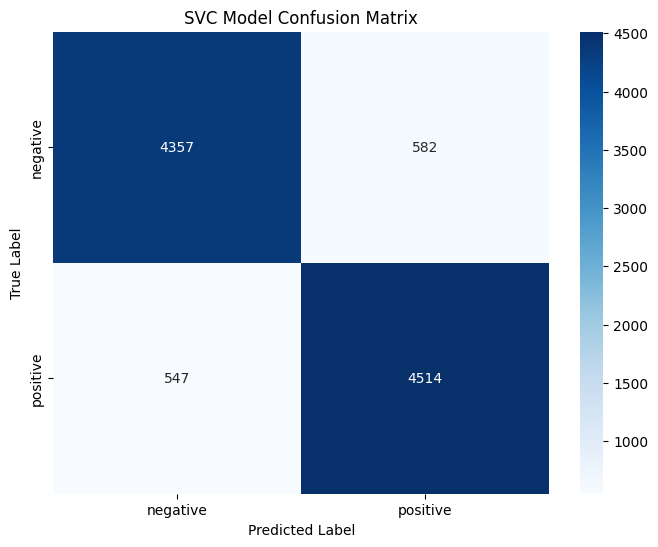


SVC Confusion Matrix:
[[4357  582]
 [ 547 4514]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if 'svc_model' in globals() and X_test_ngram is not None and y_test_ngram is not None:
    # Make predictions on the test data using the SVC model
    y_pred_svc = svc_model.predict(X_test_ngram)

    # Calculate evaluation metrics
    accuracy_svc = accuracy_score(y_test_ngram, y_pred_svc)
    precision_svc = precision_score(y_test_ngram, y_pred_svc, average='weighted')
    recall_svc = recall_score(y_test_ngram, y_pred_svc, average='weighted')
    f1_svc = f1_score(y_test_ngram, y_pred_svc, average='weighted')

    print("SVC Model Evaluation Results:")
    print(f"Accuracy: {accuracy_svc:.4f}")
    print(f"Precision: {precision_svc:.4f}")
    print(f"Recall: {recall_svc:.4f}")
    print(f"F1-score: {f1_svc:.4f}")

    # Print a detailed classification report
    print("\nSVC Classification Report:")
    print(classification_report(y_test_ngram, y_pred_svc))

    # Generate the confusion matrix
    cm_svc = confusion_matrix(y_test_ngram, y_pred_svc)

    # Get the class labels from the test data and sort them
    labels_svc = sorted(y_test_ngram.unique())

    # Display the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=labels_svc, yticklabels=labels_svc)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('SVC Model Confusion Matrix')
    plt.show()

    print("\nSVC Confusion Matrix:")
    print(cm_svc)

else:
    print("SVC model or test data not available. Cannot perform evaluation.")

In [ ]:
# Create a DataFrame for misclassified instances
# Ensure df_sentiment is available and contains the original reviews
if 'df_sentiment' in globals() and 'y_test_ngram' in globals() and 'y_pred_ngram' in globals():
    # Get the indices of the test set
    # We need to use the original indices from df_sentiment to get the review text
    # Assuming the split was done on the original df_sentiment index
    # This requires the original df_sentiment index to be preserved during the split
    # Let's recreate a temporary dataframe from the test split to get original reviews
    # Note: A more robust approach would store original indices during the split

    # Create a temporary dataframe from the test split to access original reviews
    temp_df_test = pd.DataFrame({
        'review': df_sentiment.loc[y_test_ngram.index, 'review'],
        'true_sentiment': y_test_ngram,
        'predicted_sentiment': y_pred_ngram
    })

    # Filter for misclassified instances
    misclassified_df = temp_df_test[temp_df_test['true_sentiment'] != temp_df_test['predicted_sentiment']].copy()

    print(f"Found {len(misclassified_df)} misclassified instances.")

    # Display a random sample of misclassified instances
    if len(misclassified_df) > 0:
        print("\nSample of misclassified sentences:")
        display(misclassified_df.sample(min(10, len(misclassified_df)), random_state=42)) # Display up to 10 samples
    else:
        print("No misclassified instances found in the sample.")

else:
    print("Required dataframes (df_sentiment, y_test_ngram, y_pred_ngram) not available.")

# Based on the displayed samples, analyze patterns of misclassification.
# This analysis step is manual based on the output.

Found 1076 misclassified instances.

Sample of misclassified sentences:


,review,true_sentiment,predicted_sentiment
13513,b'I notice that most of the people who think t...,negative,positive
96648,"b'After seeing the movie, I feel the father an...",negative,positive
86458,b'There are lot of similarities between Never ...,positive,negative
80361,"b""The obsession of 'signifie' and 'signifiant'...",negative,positive
67776,"b""Ironic that Dr. Seuss' fable emphasizing the...",negative,positive
23936,b'I would give this show a ten out of ten if i...,positive,negative
1379,"b""I saw this movie the first time at about twe...",negative,positive
82804,"b'I have seen this movie several times, it sur...",negative,positive
25989,"b""After seeing MIDNIGHT OFFERINGS I am still c...",negative,positive
40099,"b'I really, really didn\'t expect this type of...",negative,positive


In [ ]:
from sklearn.model_selection import cross_val_score

if 'model_ngram' in globals() and 'X_train_ngram' in globals() and 'y_train_ngram' in globals():
    # Perform 5-fold cross-validation
    print("Performing 5-fold cross-validation on the retrained model...")
    cv_scores = cross_val_score(model_ngram, X_train_ngram, y_train_ngram, cv=5)

    # Print the cross-validation scores for each fold
    print("\nCross-validation scores for each fold:", cv_scores)

    # Calculate and print the mean and standard deviation of the scores
    print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}")

else:
    print("Retrained n-gram model or training data not available. Cannot perform cross-validation.")

Performing 5-fold cross-validation on the retrained model...

Cross-validation scores for each fold: [0.893375 0.890625 0.88975  0.885625 0.88825 ]
Mean cross-validation accuracy: 0.8895
Standard deviation of cross-validation accuracy: 0.0026


In [ ]:
if 'df_sentiment' in globals() and df_sentiment is not None:
    display(df_sentiment.head())
else:
    print("df_sentiment is not defined or is None.")

,review,sentiment,cleaned_review,rooted_tokens,rooted_text
3,"b""Dan Katzir has produced a wonderful film tha...",positive,dan katzir has produced a wonderful film that ...,"[dan, katzir, produc, wonder, film, take, us, ...",dan katzir produc wonder film take us rollerco...
4,b'If you want Scream or anything like the big-...,positive,if you want scream or anything like the bigstu...,"[want, scream, anyth, like, bigstudio, horror,...",want scream anyth like bigstudio horror produc...
9,"b""Outlandish premise that rates low on plausib...",negative,outlandish premise that rates low on plausibil...,"[outlandish, premis, rate, low, plausibl, unfo...",outlandish premis rate low plausibl unfortun a...
11,b'Let\'s face it-- if you rented a STDVD seque...,negative,lets face it if you rented a stdvd sequel of a...,"[let, face, rent, stdvd, sequel, forgotten, 80...",let face rent stdvd sequel forgotten 80 gem ex...
12,b'Bizarre Tobe Hooper exercise regarding an un...,negative,bizarre tobe hooper exercise regarding an unfo...,"[bizarr, tobe, hooper, exercis, regard, unfort...",bizarr tobe hooper exercis regard unfortun you...


In [ ]:
import gradio as gr
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ensure necessary NLTK data is downloaded (same as in previous cells)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# Define the prediction function for the Gradio interface using the SVC model
def predict_sentiment_svc(sentence):
    if 'svc_model' not in globals() or 'tfidf_vectorizer_ngram' not in globals():
        return "Error: SVC model or TF-IDF vectorizer not found. Please run the training steps."

    # Preprocess the input sentence
    cleaned_sentence = preprocess_text(sentence)

    # Tokenize and root the cleaned sentence
    rooted_tokens = tokenize_and_root(cleaned_sentence)
    rooted_text = ' '.join(rooted_tokens)

    # Vectorize the rooted text using the n-gram TF-IDF vectorizer
    # Ensure the vectorizer is the one fitted on the training data (tfidf_vectorizer_ngram)
    try:
        X_new_ngram = tfidf_vectorizer_ngram.transform([rooted_text])
    except Exception as e:
        return f"Error during vectorization: {e}"

    # Predict sentiment using the trained SVC model
    try:
        predicted_sentiment = svc_model.predict(X_new_ngram)
        return predicted_sentiment[0]
    except Exception as e:
        return f"Error during prediction: {e}"

# Define the Gradio interface for the SVC model
if 'predict_sentiment_svc' in globals():
    svc_interface = gr.Interface(
        fn=predict_sentiment_svc,  # Our SVC prediction function
        inputs=gr.Textbox(lines=5, label="Enter Sentence for Sentiment Analysis (SVC Model)"), # Text input
        outputs=gr.Label(label="Predicted Sentiment (SVC Model)"), # Label output for sentiment
        title="Sentiment Analysis Predictor (SVC Model)",
        description="Enter a sentence and get its predicted sentiment (Positive or Negative) using the trained SVC model."
    )

    # Launch the interface
    print("Launching SVC Gradio interface...")
    # Set share=True to get a public link (optional) - useful for sharing demos
    # Set inline=False if you prefer to open in a new tab
    svc_interface.launch(share=True)

else:
    print("The 'predict_sentiment_svc' function is not defined. Gradio interface cannot be launched.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Launching SVC Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://10f797de6c0043dfaa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
